In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skbio.diversity
import seaborn as sns
from skbio.diversity import alpha_diversity
from skbio.diversity.alpha import shannon, simpson, chao1, observed_otus, pielou_e
from scipy.stats import mannwhitneyu

In [6]:
df = pd.read_csv("../FINAL_SPECIES_RAW.csv")

In [7]:
#set up reads for rarefaction / RPCA
df = pd.read_csv("../FINAL_SPECIES_RAW.csv")
if 'Row_Sum' in df.columns:
    df = df.drop(columns=['Row_Sum'])

#figure out appropriate sampling depth for Rarefaction
reads = df.iloc[:,14:]

df['Row_Sum'] = reads.iloc[:,:].sum(axis=1)

#figure out exact number of breaking point
depths = df['Row_Sum'][df['Row_Sum'] > 20000]
rarefaction_depth = depths.sort_values().iloc[0]

# Filtering out samples with total reads less than the rarefaction depth
filtered_df = df[df['Row_Sum'] >= rarefaction_depth].copy().reset_index(drop=True)
reads_filtered = filtered_df.iloc[:, 14:-1]
group_labels = filtered_df['Group']

In [8]:
#DELETE FEATURES WITH NO OCCURENCES

# Step 1: Calculate the number of non-zero occurrences for each feature (species)
non_zero_counts = (reads_filtered != 0).sum(axis=0)

# Step 2: Identify features that occur in no samples
no_sample_features = non_zero_counts[non_zero_counts == 0]

# Step 3: Drop these features (species) from reads_filtered
if len(no_sample_features) > 0:
    reads_filtered_cleaned = reads_filtered.drop(columns=no_sample_features.index)
    print(f"Removed {len(no_sample_features)} species that occur in no samples.")
else:
    reads_filtered_cleaned = reads_filtered
    print("No species were removed; all species occur in at least one sample.")

# Step 4: Check the shape of the cleaned data
print(f"Original shape of reads_filtered: {reads_filtered.shape}")
print(f"Shape after cleaning: {reads_filtered_cleaned.shape}")

reads_filtered = reads_filtered_cleaned

Removed 84 species that occur in no samples.
Original shape of reads_filtered: (303, 1130)
Shape after cleaning: (303, 1046)


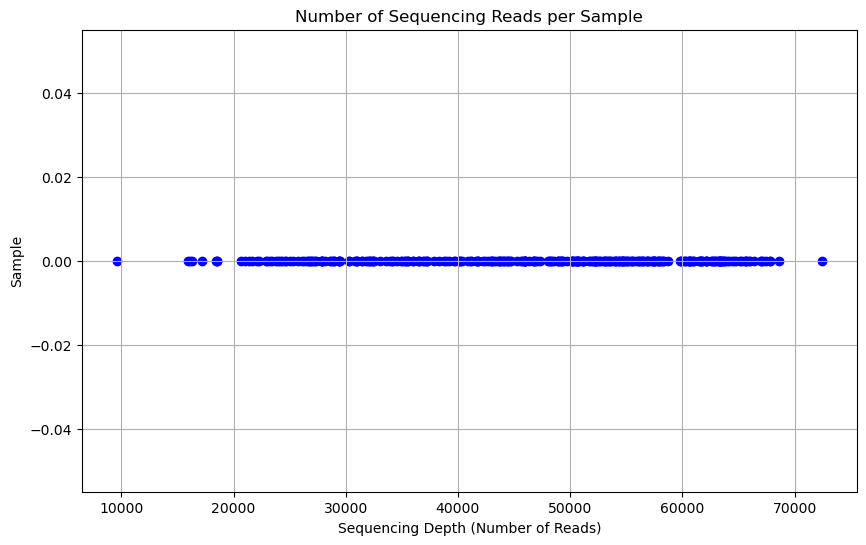

In [9]:
# Plotting the sequencing depth for each sample
plt.figure(figsize=(10, 6))
plt.scatter(df['Row_Sum'], np.zeros(311), color='blue')

# Adding labels and title
plt.xlabel('Sequencing Depth (Number of Reads)')
plt.ylabel('Sample')
plt.title('Number of Sequencing Reads per Sample')

# Show the plot
plt.grid(True)
plt.show()

In [10]:
#figure out exact number of breaking point
depths = df["Row_Sum"][df["Row_Sum"] > 20000]
rarefaction_depth = depths.sort_values()[0]

In [11]:
rarefaction_depth

23806

In [12]:


# Function to perform rarefaction (subsampling) on a row (sample)
def rarefy_row(row, rarefaction_depth):
    """Rarefy a row by subsampling reads up to rarefaction_depth."""
    total_reads = row.sum()
    
    if total_reads < rarefaction_depth:
        # If total reads are less than the rarefaction depth, return the original row
        return row
    else:
        # Sample without replacement
        proportions = row / total_reads
        rarefied = np.random.multinomial(rarefaction_depth, proportions)
        return rarefied

# Perform rarefaction manually for 1000 iterations
num_reps = 1000
rarefied_alpha_diversities = {metric: [] for metric in ['shannon', 'simpson', 'chao1', 'observed_otus', 'pielou']}

for _ in range(num_reps):
    # Perform rarefaction on the reads and convert to DataFrame
    subsampled_reads = reads_filtered.apply(lambda row: rarefy_row(row, rarefaction_depth), axis=1)
    subsampled_reads = pd.DataFrame(np.array(subsampled_reads.tolist()), index=subsampled_reads.index, columns=reads_filtered.columns)
    
    # Calculate alpha diversity metrics for each subsampled iteration
    rarefied_alpha_diversities['shannon'].append(alpha_diversity('shannon', subsampled_reads))
    rarefied_alpha_diversities['simpson'].append(alpha_diversity('simpson', subsampled_reads))
    rarefied_alpha_diversities['chao1'].append(alpha_diversity('chao1', subsampled_reads))
    rarefied_alpha_diversities['observed_otus'].append(alpha_diversity('observed_otus', subsampled_reads))
    
    # Calculate Pielou's Evenness for each rarefied sample
    shannon_values = rarefied_alpha_diversities['shannon'][-1]
    observed_otus_values = rarefied_alpha_diversities['observed_otus'][-1]
    
    # Pielou's Evenness calculation over each sample (ensure 1D input)
    pielou_evenness_values = [
        pielou_e(subsampled_reads.iloc[i].values) for i in range(subsampled_reads.shape[0])
    ]
    rarefied_alpha_diversities['pielou'].append(pielou_evenness_values)

# Average the metrics across the 1000 rarefactions
averaged_alpha_diversities = {
    metric: pd.DataFrame(rarefied_alpha_diversities[metric]).mean(axis=0)
    for metric in ['shannon', 'simpson', 'chao1', 'observed_otus', 'pielou']
}

# Creating a DataFrame for storing alpha diversity metrics
alpha_diversity_df = pd.DataFrame({
    'Shannon': averaged_alpha_diversities['shannon'],
    'Simpson': averaged_alpha_diversities['simpson'],
    'Chao1': averaged_alpha_diversities['chao1'],
    'OTU_Richness': averaged_alpha_diversities['observed_otus'],
    'Pielou_Evenness': averaged_alpha_diversities['pielou'],
    'Group': group_labels.values
})

# Save the alpha diversity data to a CSV
alpha_diversity_df.to_csv("alpha_diversity_metrics1.csv", index=False)


/root/anaconda3/envs/SG90/lib/python3.9/site-packages/skbio/util/_warning.py:60: UserWarning: observed_otus is deprecated as of 0.6.0.
  warn(f"{func.__name__} is deprecated as of {ver}.")


/tmp/ipykernel_3125/2547420954.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x=group_col, y=metric, data=df, inner=None, palette="Set2", cut=0)
/tmp/ipykernel_3125/2547420954.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


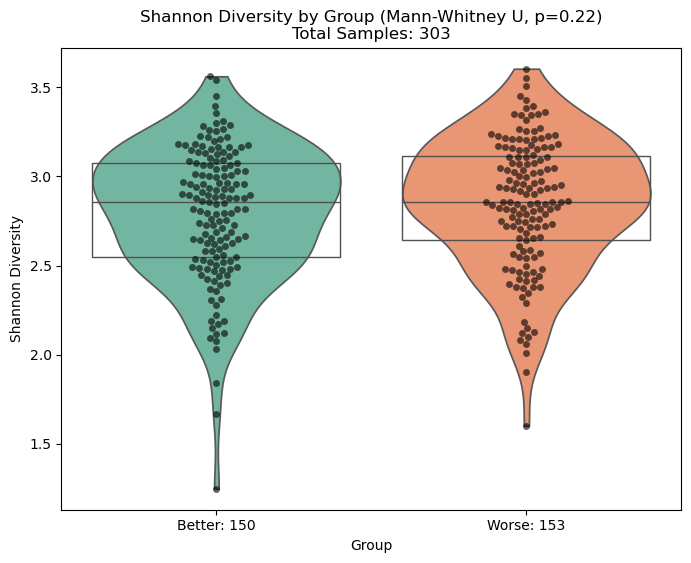

/tmp/ipykernel_3125/2547420954.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x=group_col, y=metric, data=df, inner=None, palette="Set2", cut=0)
/tmp/ipykernel_3125/2547420954.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


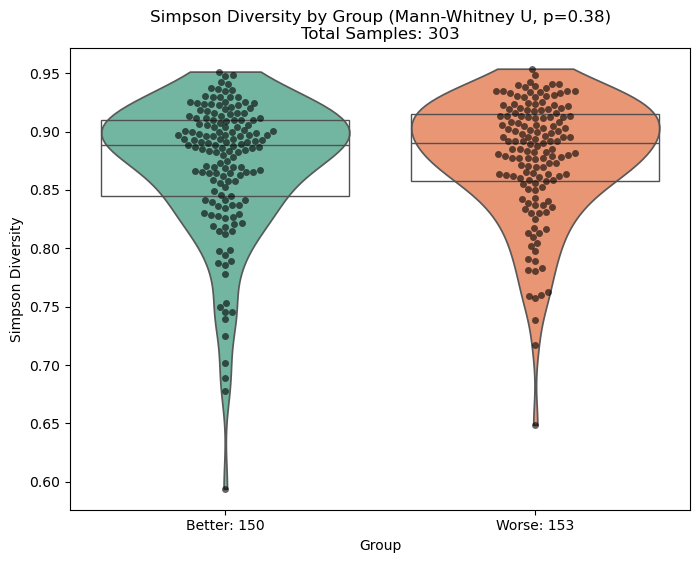

/tmp/ipykernel_3125/2547420954.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x=group_col, y=metric, data=df, inner=None, palette="Set2", cut=0)
/tmp/ipykernel_3125/2547420954.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


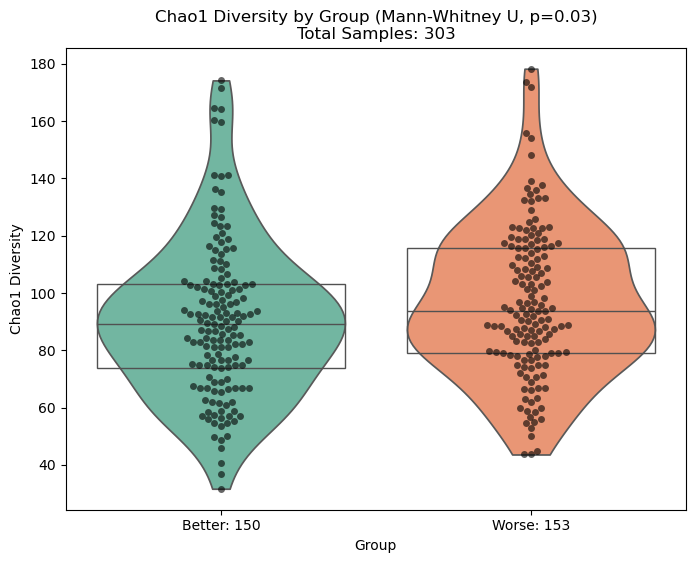

/tmp/ipykernel_3125/2547420954.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x=group_col, y=metric, data=df, inner=None, palette="Set2", cut=0)
/tmp/ipykernel_3125/2547420954.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


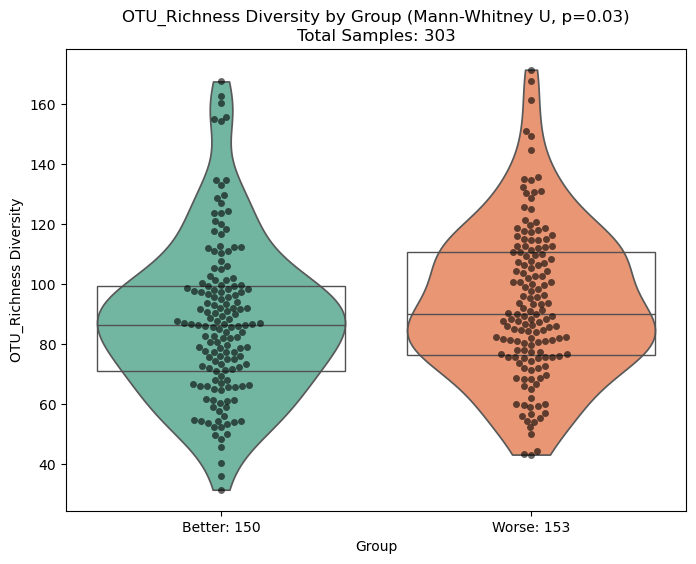

/tmp/ipykernel_3125/2547420954.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x=group_col, y=metric, data=df, inner=None, palette="Set2", cut=0)
/tmp/ipykernel_3125/2547420954.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)


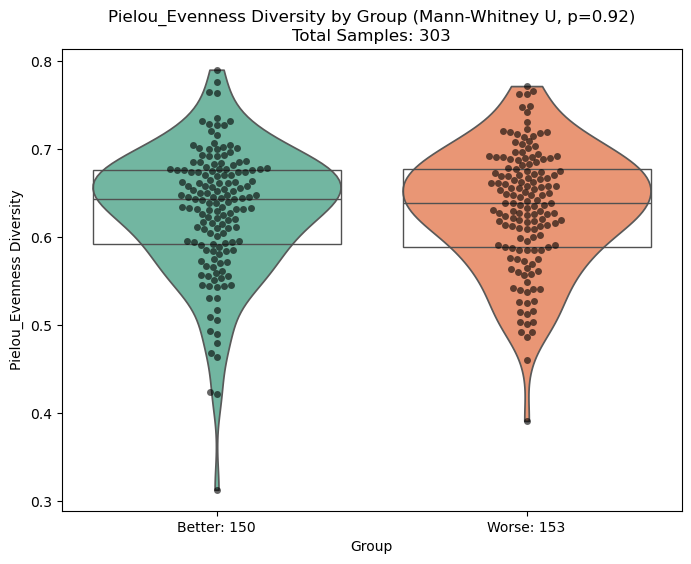

In [13]:
# Function to create violin plot with custom labels and group sizes
def plot_violin(metric, df, group_col='Group'):
    plt.figure(figsize=(8, 6))
    
    # Calculate group sizes
    n_total = len(df)
    n_better = len(df[df[group_col] == 'Better'])
    n_worse = len(df[df[group_col] == 'Worse'])
    
    # Update x-tick labels to include group sizes
    x_labels = [f"Better: {n_better}", f"Worse: {n_worse}"]
    
    # Create the violin plot
    ax = sns.violinplot(x=group_col, y=metric, data=df, inner=None, palette="Set2", cut=0)
    
    # Add mean and standard deviation as a box plot inside the violin plot
    sns.boxplot(x=group_col, y=metric, data=df, showcaps=False, boxprops={'facecolor':'None'}, 
                showfliers=False, whiskerprops={'linewidth':0}, ax=ax)
    
    # Calculate Mann-Whitney U test
    group1 = df[df[group_col] == 'Better'][metric]
    group2 = df[df[group_col] == 'Worse'][metric]
    
    # Perform Mann-Whitney U test
    stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')
    
    # Annotate p-value and group sizes in the title
    plt.title(f'{metric} Diversity by Group (Mann-Whitney U, p={p_val:.2f})\nTotal Samples: {n_total}')
    plt.ylabel(f'{metric} Diversity')
    plt.xlabel('Group')
    
    # Set the custom x-axis labels
    ax.set_xticklabels(x_labels)
    
    # Add scatter points for each sample
    sns.swarmplot(x=group_col, y=metric, data=df, color="k", alpha=0.6, ax=ax)
    
    # Save the plot to the current directory or a specific path
    plt.savefig(f"{metric}_alpha_diversity1.png")
    
    # Display the plot
    plt.show()
    
    plt.close()

# Create and save violin plots for each diversity metric, including Pielou's Evenness
for metric in ['Shannon', 'Simpson', 'Chao1', 'OTU_Richness', 'Pielou_Evenness']:
    plot_violin(metric, alpha_diversity_df)
